## Plan
1. Read labelled corpus of words and their corresponding language (MSA or TND).
2. Split data into training and test sets.
3. Representation of words as numeric feature vectors using **bag-of-ngrams** with tfidf feature weighting.
4. Automatic feature selection based on mutual information.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [8]:
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

In [9]:
# Add higher directory to python modules path.

import sys
sys.path.append("..")

In [10]:
# Local utility functions
from utilities import machine_learning_utils

****

## Load word data from file

In [11]:
#?pd.read_csv

In [12]:
filename = '../../results/Arabic_words_corpus_final.csv'
df = pd.read_csv(filename, names=['word','lang_label'],header=None)
df.head()

,word,lang_label
0,آئ,MSA
1,آب,MSA
2,آباء,MSA
3,آبائه,MSA
4,آبائهم,MSA


In [13]:
df.shape

(47682, 2)

In [14]:
words_list = df.word.tolist()
labels_list = df.lang_label.tolist()
assert(len(words_list)==len(labels_list))
len(words_list)

47682

## Split data into train and test sets
- 75% - 25% split of the data
- since our data is imabalanced, it is important that we do a **stratified** split.

In [15]:
#?train_test_split

In [16]:
pd.Series(labels_list).value_counts()

MSA    46895
TN       787
dtype: int64

In [17]:
words_train,words_test,labels_train,labels_test = train_test_split(words_list, labels_list, test_size=0.25, stratify=labels_list, random_state=123)
len(words_train), len(words_test)

(35761, 11921)

In [18]:
pd.Series(labels_train).value_counts()

MSA    35171
TN       590
dtype: int64

****

## Representation of words using Bag-of-character-ngrams

The goal here is to represent words as numeric feature vectors of the same size. For this we will use the "Bag of character ngrams" method which consists of the following 3 basic computational steps:

1. for each word, extract all ngrams that belong to that word, with n between 1 and $N$ (where $N$ is a fixed hyperparameter). Let $V$ be the set of *distinct* ngrams extracted from all words (historically called the *vocabulary*).
2. prune the set $V$ by removing ngrams whose frequency of occurrence is below some threshold (`min_df=10`) or above some threshold (`max_df=0.9`). That is, remove ngrams that either occur too frequently or too infrequently in the training corpus.
This is really a heuristic *feature selection* process, and it roughly amounts to removing low-variance features (see https://scikit-learn.org/stable/modules/feature_selection.html).
3. for each word $w$ obtain a numeric feature vector of length $|V|$, where each feature value represents the *weight* of one ngram in the word $w$. We will do this via **tfidf weighting**.  The vectors of all words are stored in the **DTM matrix**.

*Definitions / Terminology:*

- DF ("Document Frequency") of a feature: the number of words that contain this feature.
- IDF ("Inverse Document Frequency") of a feature : 1/DF
- DTM: Document-term matrix; the $(i,j)$th element of this matrix is a numeric measure of the importance of the $i$th document to the $j$th term.

This terminology may seem strange but it is used for historical reasons; it comes from the rudimentary **bag-of-words** model originally used/designed for information retrieval applications. 

In our case, a 'document' is a word and a 'term' is a character ngram.

*Important Remark*: 

I have used the option `analyzer='char_wb'` when creating the `TfidfVectorizer` class instance so that words are left- and right- padded with n-2 spaces prior to extraction of n-grams. Padding is useful because it generates ngrams that represent the beginning and end of words. 

For example, assuming N=3, the ngrams corresponding to the 6-letter Arabic word 'مقابلة' are shown below. The bigram ' م' on the first line consists of a space followed by the letter 'م'; it hence captures words that begin with the letter 'م'. This bigram is quite different than the unigram 'م', which captures words that contain the letter 'م' anywhere in the word.  Similarly, the trigram 'لة ' captures words that end with the 2-letter sequence 'لة '.

         ' م',
         ' مق',
         'ا',
         'اب',
         'ابل',
         'ب',
         'بل',
         'بلة',
         'ة',
         'ة ',
         'ق',
         'قا',
         'قاب',
         'ل',
         'لة',
         'لة ',
         'م',
         'مق',
         'مقا'
 

In [19]:
# important hyperparameter of this method: maximum order of ngram features
N = 4

In [20]:
# Note that the min_df and max_df hyperparameters are used to filter out useless ngrams -- those that occur either too infrequently or too frequently

vectorizer = TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1, N), analyzer='char_wb')

In [21]:
dtm_train = vectorizer.fit_transform(words_train)
type(dtm_train), dtm_train.shape

(scipy.sparse.csr.csr_matrix, (35761, 8069))

In [22]:
dtm_test = vectorizer.transform(words_test)
type(dtm_test), dtm_test.shape

(scipy.sparse.csr.csr_matrix, (11921, 8069))

In [23]:
feature_names = np.asarray(vectorizer.get_feature_names())
type(feature_names),feature_names.shape

(numpy.ndarray, (8069,))

#### Checking the DTM matrix

In [24]:
# size of matrix

dtm_train.shape

(35761, 8069)

In [25]:
# range of values

dtm_train.min(),dtm_train.max()

(0.0, 0.8401152913769929)

In [26]:
# percentage of non-zero values in this matrix -- should be very sparse

dtm_train.nnz/dtm_train.shape[0]/dtm_train.shape[1]*100

0.2242982649137362

#### Exploratory analysis of some meta-properties of features (ngrams)

In [27]:
# Store some properties of the features in a data frame for convenience

feature_properties_df = pd.DataFrame({'feature':feature_names})

feature_properties_df['DF'] = np.array((dtm_train>0).sum(axis=0)).ravel()
feature_properties_df['IDF'] = vectorizer.idf_
feature_properties_df['max_tfidf'] = dtm_train.max(axis=0).toarray().ravel()
feature_properties_df = feature_properties_df[['feature', 'DF', 'IDF','max_tfidf']]

feature_properties_df.head()

,feature,DF,IDF,max_tfidf
0,آ,76,7.140836,0.684077
1,آل,11,8.999735,0.562443
2,آم,10,9.086746,0.492150
3,أ,1579,4.119461,0.475887
4,أب,86,7.018733,0.581101


In [28]:
feature_properties_df.corr()

,DF,IDF,max_tfidf
DF,1.000000,-0.486256,-0.092916
IDF,-0.486256,1.000000,-0.024668
max_tfidf,-0.092916,-0.024668,1.000000


In [29]:
# 5 features with highest DF values (i.e. that are most frequent in the corpus)
feature_properties_df.sort_values("DF", ascending=False).head()

,feature,DF,IDF,max_tfidf
1440,ا,21816,1.494196,0.230176
5792,ل,16712,1.760699,0.285738
7742,ي,11916,2.098920,0.356860
7329,و,10901,2.187940,0.334418
1873,ال,10721,2.204588,0.247885


In [30]:
# 5 features with lowest DF values (i.e. that are least frequent in the corpus)
feature_properties_df.sort_values("DF").head()

,feature,DF,IDF,max_tfidf
7103,نصب,10,9.086746,0.472617
3463,حون,10,9.086746,0.433276
5394,فلة,10,9.086746,0.403014
5393,فلة,10,9.086746,0.403014
5385,فك,10,9.086746,0.558877


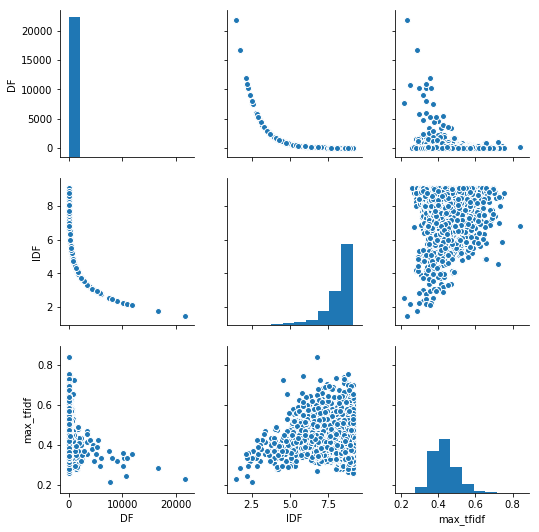

In [31]:
#feature_properties_df.plot.scatter("DF","IDF")
sns.pairplot(feature_properties_df)

#### Just for fun

relationship between number of features (ngrams) in a word and its length.

In [32]:
# How many features (ngrams) are there in each word?

temp_df = pd.DataFrame({'word':words_train})
temp_df['nb_chars'] = temp_df.word.map(len)
temp_df['nb_features'] = np.array((dtm_train>0).sum(axis=1)).ravel()
temp_df = temp_df.set_index('word')
temp_df.head()

,nb_chars,nb_features
word,,
صعد,3,9
ومعنوية,7,23
يزكي,4,10
ووضعوا,6,16
حكومته,6,20


In [33]:
temp_df.corr()

,nb_chars,nb_features
nb_chars,1.000000,0.952005
nb_features,0.952005,1.000000


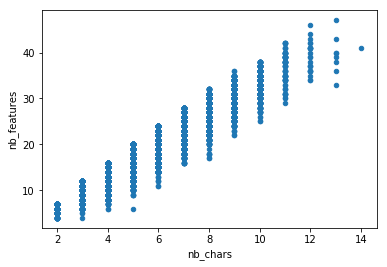

In [34]:
temp_df.plot.scatter('nb_chars','nb_features')

****

## Automatic Feature Selection

The size of our DTM matrix is 35761 by 8069. From a supervised learning point of view, this means we have 35761 training samples (feature vectors) and 8069 features. The ratio of samples to features is around 4 which seems a bit too low for effective learning to happen. Feature selection helps us increase this ratio by decreasing the number of features; more precisely by selecting a subset of the most 'important' features. 

We will explore two different measures of **feature importance** typically used in practice:

1. Chi-squared statistic,
2. Mutual information.

In [71]:
X_train = dtm_train
y_train = np.asarray(labels_train)
X_test = dtm_test
y_test = np.asarray(labels_test)

X_train.shape,y_train.shape,X_test.shape,y_test.shape,feature_names.shape

((35761, 8069), (35761,), (11921, 8069), (11921,), (8069,))

In [37]:
# This takes a little while ...

ch_score,pvalue = chi2(X_train,y_train)
feature_properties_df['chi2_score'] = ch_score
feature_properties_df['chi2_pvalue'] = pvalue
feature_properties_df['mi_score'] = mutual_info_classif(X_train,y_train)

In [38]:
feature_properties_df[['DF', 'chi2_score','chi2_pvalue','mi_score']].describe()

,DF,chi2_score,chi2_pvalue,mi_score
count,8069.000000,8.069000e+03,8.069000e+03,8069.000000
mean,80.211303,8.893110e-01,6.617825e-01,0.000155
std,522.842210,6.223618e+00,2.058945e-01,0.001077
min,10.000000,1.369525e-07,7.501794e-68,0.000005
25%,13.000000,7.303247e-02,6.307651e-01,0.000006
50%,19.000000,1.107849e-01,7.392522e-01,0.000010
75%,38.000000,2.310246e-01,7.869716e-01,0.000036
max,21816.000000,3.029496e+02,9.997047e-01,0.047703


In [39]:
feature_properties_df[['DF','chi2_score','chi2_pvalue','mi_score']].corr()

,DF,chi2_score,chi2_pvalue,mi_score
DF,1.000000,0.019733,-0.142939,0.945162
chi2_score,0.019733,1.000000,-0.374777,0.147785
chi2_pvalue,-0.142939,-0.374777,1.000000,-0.195860
mi_score,0.945162,0.147785,-0.195860,1.000000


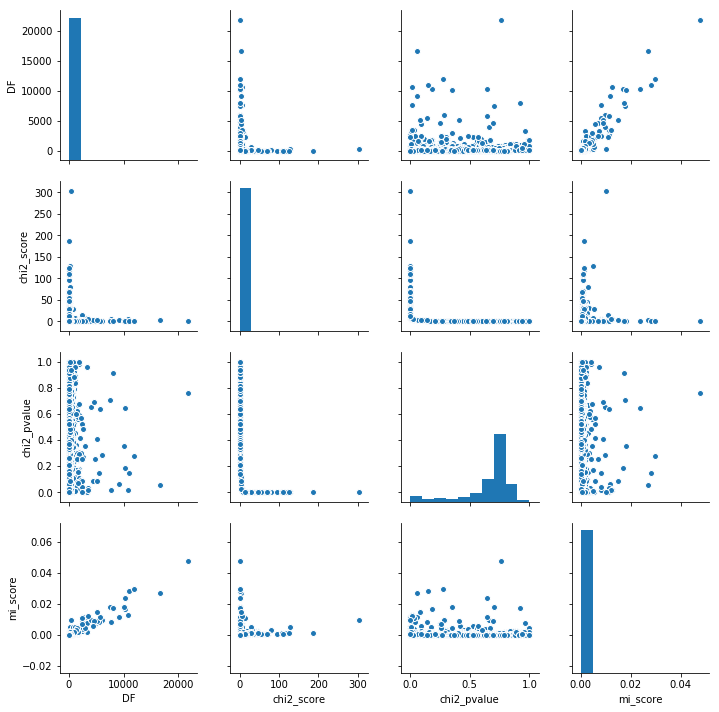

In [40]:
sns.pairplot(feature_properties_df[['DF','chi2_score','chi2_pvalue','mi_score']])

In [41]:
# feature_properties_df.plot.scatter(x='DF', y='chi2_score', loglog=True)

In [42]:
# feature_properties_df.plot.scatter(x='chi2_score', y='chi2_pvalue', logx=True)

### Visualize top features

In [43]:
# Top 5 features based on chi-squared statistic

feature_properties_df[['feature','DF','chi2_score','chi2_pvalue','mi_score']].sort_values(by='chi2_score',ascending=False).head(5)

,feature,DF,chi2_score,chi2_pvalue,mi_score
7330,و,335,302.949591,7.501794e-68,0.009915
1488,اا,13,186.041730,2.324784e-42,0.001151
4486,ش,203,127.760983,1.266079e-29,0.004816
7183,نو,19,124.455246,6.697276e-29,0.001154
3032,تو,20,118.799113,1.158916e-27,0.001155


In [44]:
# Top 5 features based on mutual information

feature_properties_df[['feature','DF','chi2_score','chi2_pvalue','mi_score']].sort_values(by='mi_score',ascending=False).head(5)

,feature,DF,chi2_score,chi2_pvalue,mi_score
1440,ا,21816,0.092783,0.760668,0.047703
7742,ي,11916,1.177065,0.277954,0.029786
7329,و,10901,2.106395,0.146684,0.028179
5792,ل,16712,3.602400,0.057696,0.026924
6549,م,10238,0.208818,0.647695,0.023739


In [45]:
words_train_df = pd.DataFrame(dict(word=words_train,lang_label=labels_train))

Top 10 Features:
Importance_score	Ngram_feature
    302.950		"و "
    186.042		"اا"
    127.761		"ش "
    124.455		"نو "
    118.799		"تو "
    110.435		"وش "
    108.808		"فو "
     95.124		"شوف"
     80.696		" ما"
     71.185		"بو "

feature: "و "

Number of training words that contain this feature: 335

Distribution of language labels of words that contain this feature:
     contain this feature  total  % of total
MSA                   251  35171    0.713656
TN                     84    590   14.237288

Example training words that contain this feature:
  MSA: ['دييغو', 'مونشو', 'ألفونسو', 'اليونسكو', 'دو', 'اللهو', 'فانواتو', 'للنمو', 'العدو', 'ميناموتو']
  TND: []

feature: "اا"

Number of training words that contain this feature: 13

Distribution of language labels of words that contain this feature:
     contain this feature  total  % of total
TN                     10    590    0.008530
MSA                     3  35171    1.694915

Example training words that contain this featur

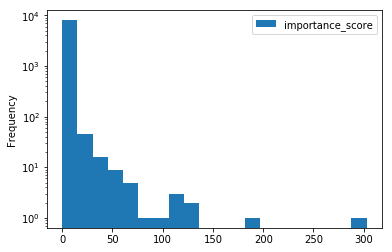

In [46]:
machine_learning_utils.analyze_feature_importance(feature_properties_df.chi2_score,feature_names,words_train_df,X_train)

Top 10 Features:
Importance_score	Ngram_feature
      0.048		"ا"
      0.030		"ي"
      0.028		"و"
      0.027		"ل"
      0.024		"م"
      0.018		"ر"
      0.018		"ب"
      0.017		"ن"
      0.017		"ت"
      0.015		"ه"

feature: "ا"

Number of training words that contain this feature: 21816

Distribution of language labels of words that contain this feature:
     contain this feature  total  % of total
MSA                 21488  35171   61.095789
TN                    328    590   55.593220

Example training words that contain this feature:
  MSA: ['ووضعوا', 'إختفاء', 'بيوتنا', 'والرقص', 'اليومين', 'بالحيوية', 'الهوى', 'احراز', 'مؤتمرات', 'والمشاركة']
  TND: []

feature: "ي"

Number of training words that contain this feature: 11916

Distribution of language labels of words that contain this feature:
     contain this feature  total  % of total
MSA                 11704  35171   33.277416
TN                    212    590   35.932203

Example training words that contain this feature:
  M

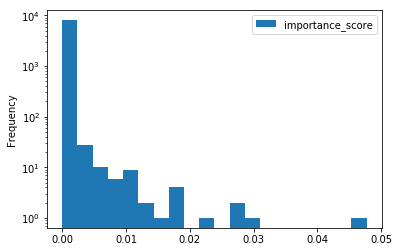

In [47]:
machine_learning_utils.analyze_feature_importance(feature_properties_df.mi_score,feature_names,words_train_df,X_train)

*Remarks and Conclusions:*

Based on qualitative visual inspection of the words containing top features (see results above), it appears that the **Chi-squared statistic** is better than mutual information at discerning important features. Thus that is what we are going to use for automatic feature selection below.

### Select top K features

- We use **Chi-squared** scores because they seem much better than mutual information at finding discriminant features.
- We will now first choose a good cutoff threshold by visually inspecting the ECDF of chi-squared scores (see red plot below).
- Then, based on this threshold, we choose the value of $K$, the number of top-scoring features to keep.

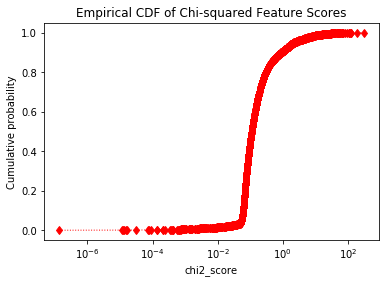

In [48]:
# ECDF of chi2 scores

# compute the ECDF of our data sample
qe, pe = machine_learning_utils.ecdf(feature_properties_df.chi2_score)

# plot
plt.plot(qe, pe, ':dr', lw=1)
plt.xscale('log')
plt.xlabel('chi2_score')
plt.ylabel('Cumulative probability')
plt.title('Empirical CDF of Chi-squared Feature Scores')
plt.show()

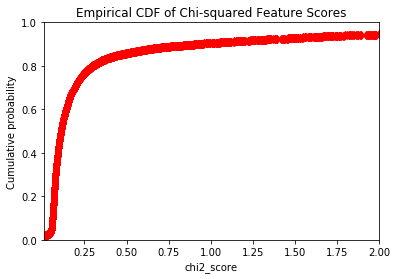

In [52]:
plt.plot(qe, pe, ':dr', lw=1)
#plt.xscale('log')
plt.xlabel('chi2_score')
plt.ylabel('Cumulative probability')
plt.title('Empirical CDF of Chi-squared Feature Scores')
plt.axis([0.01,2,0,1])
plt.show()

In [61]:
# choose the cutoff threshold via visual inspection of the above ECDF plot
prob_cutoff_threshold = 0.6

# approximately the number of top-scoring features we should keep
K_approx = feature_properties_df.shape[0]*(1-prob_cutoff_threshold)
K_approx

3227.6000000000004

In [77]:
# finally set the value of K to a nice round number
K = 3000

In [78]:
# determine subset of selected features
ch2 = SelectKBest(chi2, k=K)

In [79]:
# update training variables accordingly
X_train_sub = ch2.fit_transform(X_train, y_train)
X_test_sub = ch2.transform(X_test)
idx = ch2.get_support(indices=True)
feature_names_sub = feature_names[idx]
feature_properties_df_sub = feature_properties_df.loc[idx]

X_train_sub.shape,X_test_sub.shape,feature_names_sub.shape,feature_properties_df_sub.shape

((35761, 3000), (11921, 3000), (3000,), (3000, 7))

In [80]:
import pickle
pickle.dump([X_train_sub,y_train,X_test_sub,y_test,feature_names_sub,words_train_df], open("../../generated_data/word_data_features.p", "wb"))

*****

In [81]:
pd.Series(labels_train).value_counts()

MSA    35171
TN       590
dtype: int64